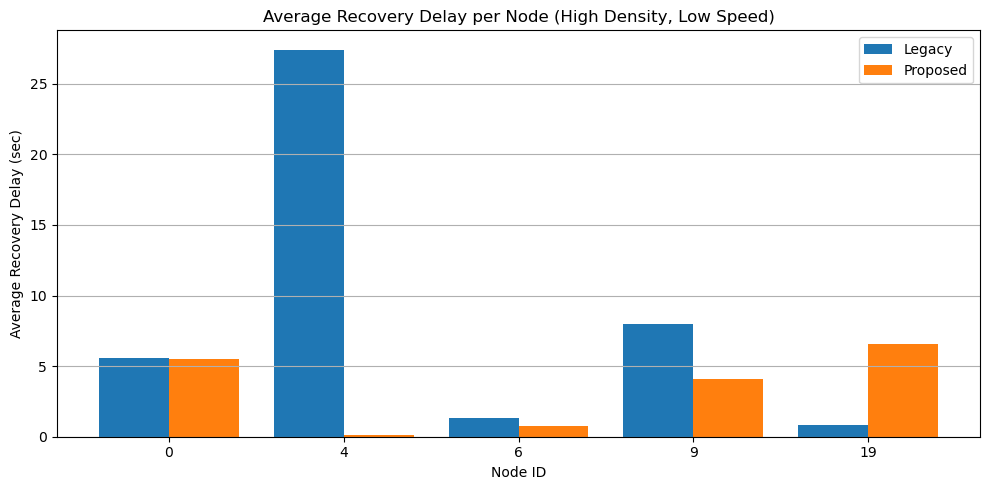

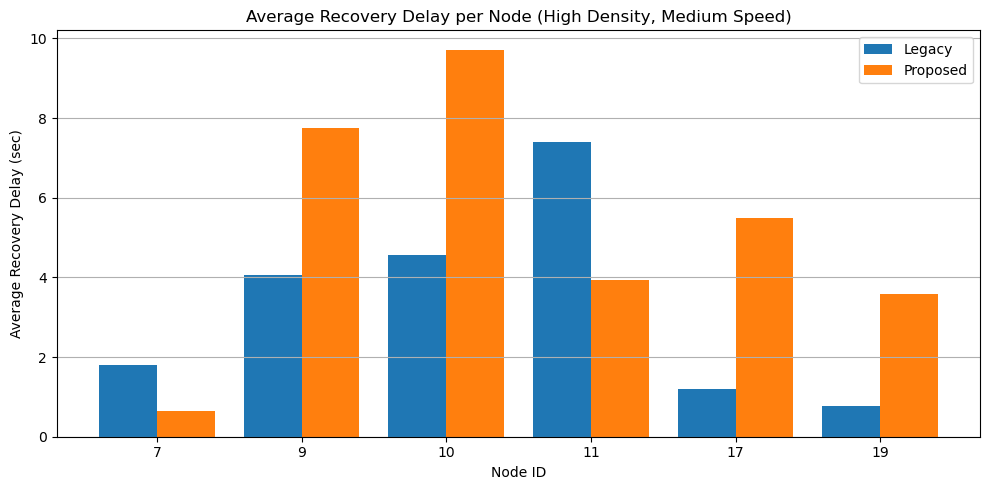

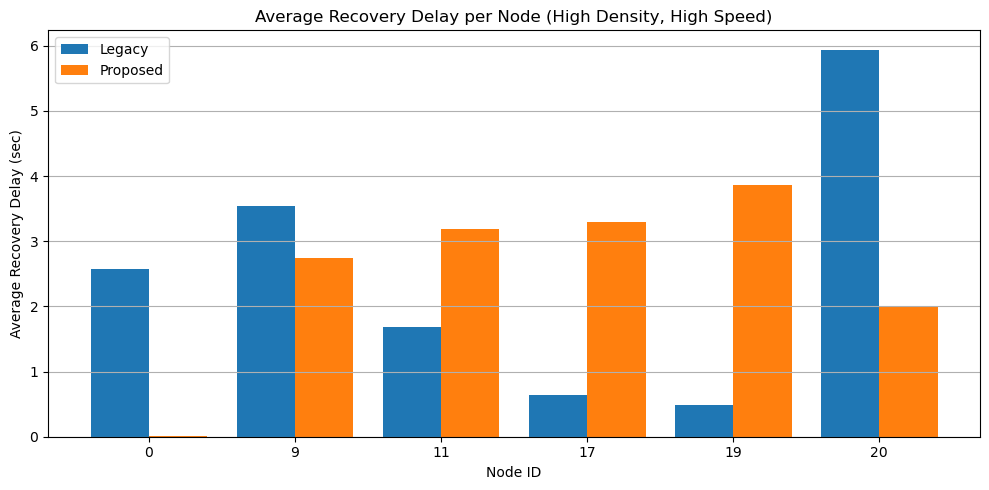

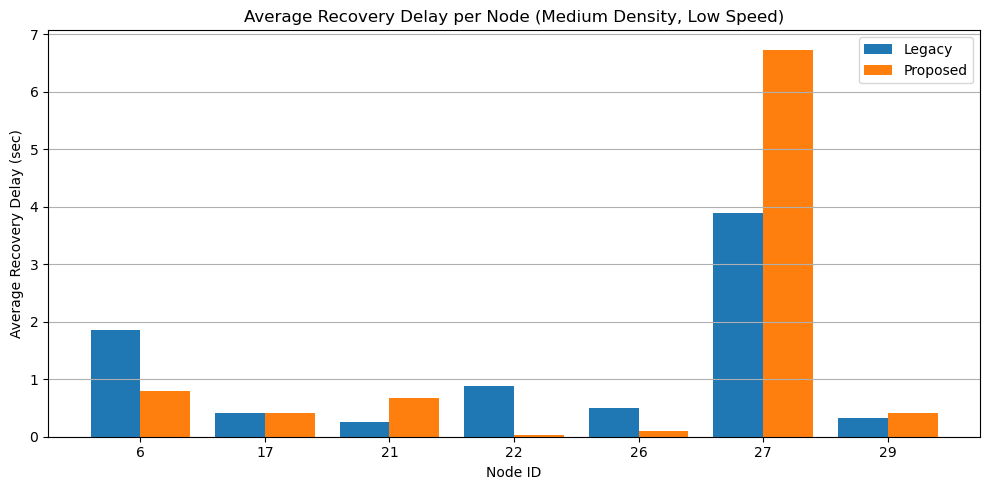

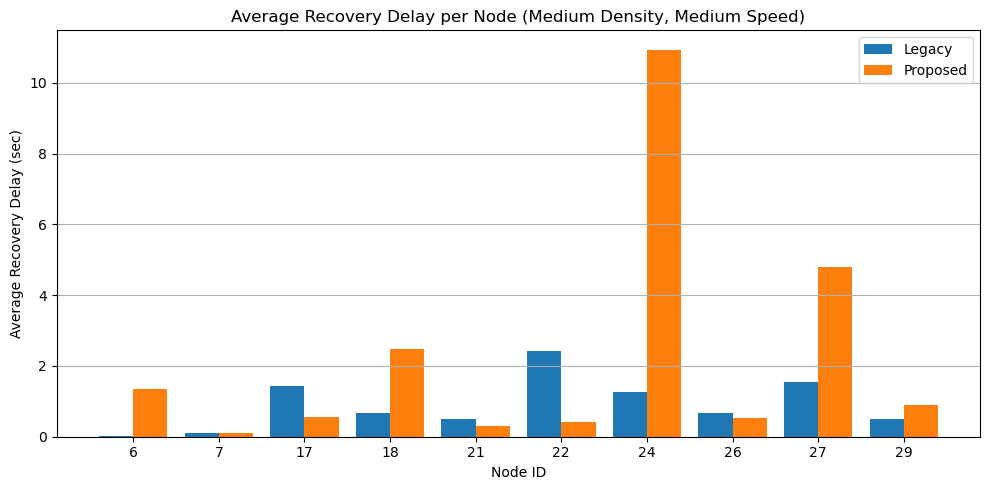

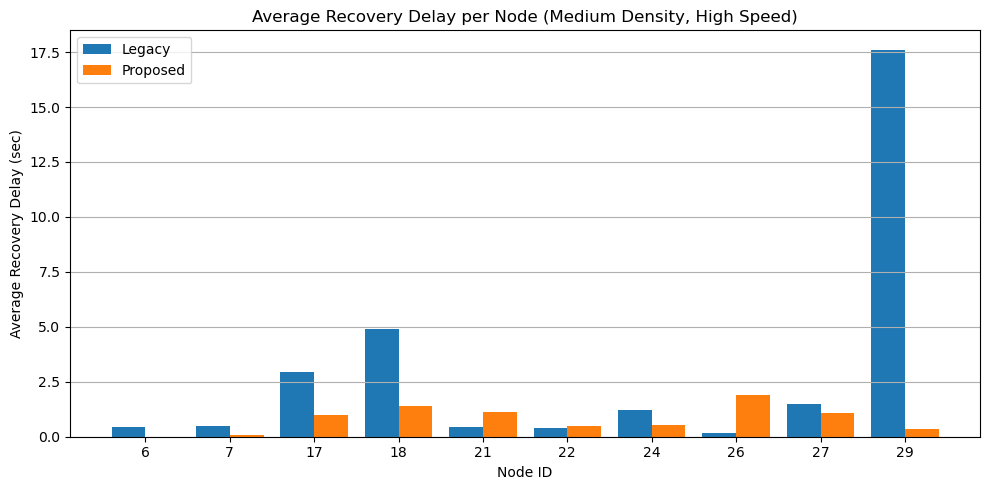

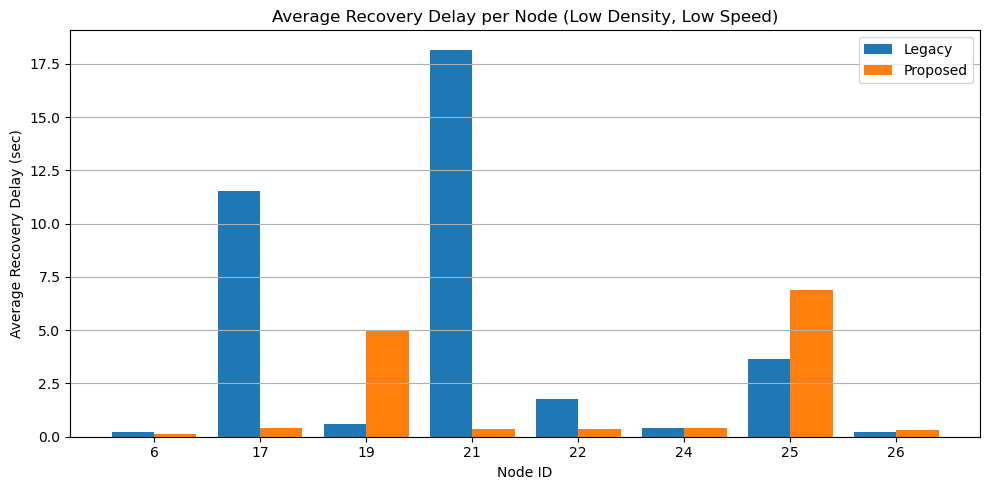

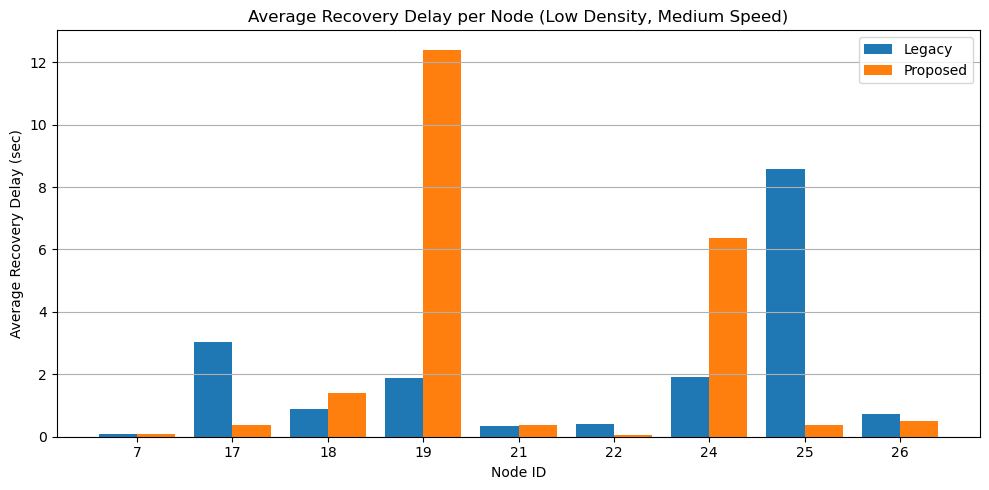

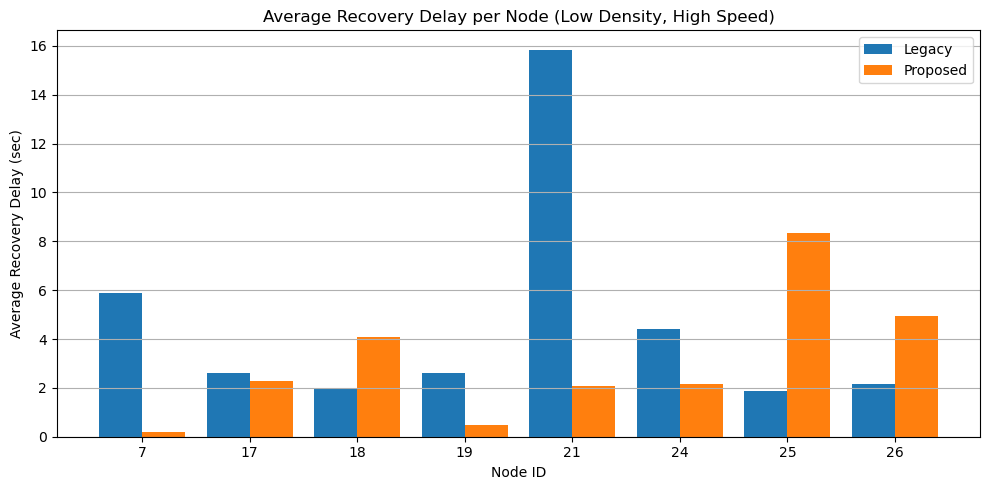

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

density_levels = ["고밀도", "중밀도", "저밀도"]
speed_levels = ["저속", "중속", "고속"]

density_map = {"고밀도": "High", "중밀도": "Medium", "저밀도": "Low"}
speed_map = {"저속": "Low", "중속": "Medium", "고속": "High"}

node_dict = {
    ("고밀도", "저속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "중속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "고속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("중밀도", "저속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "중속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "고속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("저밀도", "저속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "중속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "고속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
}

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/"

def calculate_recovery_delay(log_path):
    df = pd.read_csv(log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    delays = []
    grouped = df.groupby(["Node", "Destination"])

    for (node, dest), group in grouped:
        group = group.sort_values("Time")
        rerr_times = group[group["Event"] == "RERR_SENT"]["Time"].tolist()
        rrep_times = group[group["Event"] == "RREP_RECV"]["Time"].tolist()

        i = j = 0
        while i < len(rerr_times) and j < len(rrep_times):
            if rrep_times[j] > rerr_times[i]:
                delays.append(rrep_times[j] - rerr_times[i])
                i += 1
                j += 1
            else:
                j += 1
    return delays

for density in density_levels:
    for speed in speed_levels:
        node_list = node_dict.get((density, speed), [])
        if not node_list:
            continue

        legacy_avgs = []
        proposed_avgs = []
        node_ids = []

        for node_id in node_list:
            legacy_log = os.path.join(base_path, density, speed, "기존", str(node_id), "recovery_log.csv")
            proposed_log = os.path.join(base_path, density, speed, "제안", str(node_id), "recovery_log.csv")

            if not os.path.exists(legacy_log) or not os.path.exists(proposed_log):
                continue

            legacy_delays = calculate_recovery_delay(legacy_log)
            proposed_delays = calculate_recovery_delay(proposed_log)

            legacy_avg = sum(legacy_delays) / len(legacy_delays) if legacy_delays else None
            proposed_avg = sum(proposed_delays) / len(proposed_delays) if proposed_delays else None

            legacy_avgs.append(legacy_avg)
            proposed_avgs.append(proposed_avg)
            node_ids.append(node_id)

        filtered = [(n, l, p) for n, l, p in zip(node_ids, legacy_avgs, proposed_avgs) if l is not None and p is not None]
        if not filtered:
            continue

        node_ids, legacy_avgs, proposed_avgs = zip(*filtered)
        x = np.arange(len(node_ids))

        d_label = density_map.get(density, density)
        s_label = speed_map.get(speed, speed)

        plt.figure(figsize=(10, 5))
        plt.bar(x - 0.2, legacy_avgs, width=0.4, label='Legacy')
        plt.bar(x + 0.2, proposed_avgs, width=0.4, label='Proposed')

        plt.xticks(x, [str(n) for n in node_ids])
        plt.xlabel("Node ID")
        plt.ylabel("Average Recovery Delay (sec)")
        plt.title(f"Average Recovery Delay per Node ({d_label} Density, {s_label} Speed)")
        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()
